# Custom Embedded Runge-Kutta Method

In [1]:
!pip install fastrk matplotlib

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from numba import jit, cfunc
from fastrk import (ButcherTable, RKCodeGen,
                    EventsCodeGen, default_jitkwargs)
import bt_456_custom


### Create python file with Butcher Table elements
- matrix A
- vectors b_main, b_subs, c
- and tuple of orders

In [3]:
!type bt_456_custom.py

'''Butcher Table for RK4(5)6 from Prince and Dormand.
Original matlab code at:
https://github.com/USNavalResearchLaboratory/TrackerComponentLibrary/blob/master/Mathematical_Functions/Differential_Equations/RungeKStep.m
'''


A = [
     [0, 0, 0, 0, 0, 0],
     [1 / 4, 0, 0, 0, 0, 0],
     [3 / 32, 9 / 32, 0, 0, 0, 0],
     [1932 / 2197, -7200 / 2197, 7296 / 2197, 0, 0, 0],
     [439 / 216, -8, 3680 / 513, -845 / 4104, 0, 0],
     [-8 / 27, 2, -3544 / 2565, 1859 / 4104, -11 / 40, 0]
    ]

c = [0, 1 / 4, 3 / 8, 12 / 13, 1, 1 / 2]

b_main = [25 / 216, 0,  1408 / 2565,   2197 / 4104,  -1 / 5,      0]

b_subs = [16 / 135, 0, 6656 / 12825, 28561 / 56430, -9 / 50, 2 / 55]

order = (4, 5)


In [4]:
BT456 = ButcherTable("456", bt_456_custom)

# rk_456.py will be created and imported here
rk_module = RKCodeGen(BT456, autonomous=False).save_and_import()
rk_prop = rk_module.rk_prop

In [5]:
# using of cfunc decorator instead of jit decorator allows you to compile separately
# ODE right part and rk_prop with no recompilation required on next run
@cfunc('f8[:](f8, f8[:])')
def eq(t, s):
    '''
    Mathematical pendulum equation set.

    Parameters
    ----------

    t: scalar
        time

    s: np.array
        state vector [theta, omega]

    Return
    ------

    ds: np.array
        ds/dt - time derivative of state vector
    '''
    theta, omega = s
    return np.array([omega, -math.sin(theta)])

In [6]:
N = 100
ws = np.linspace(0, 2, N+2)[1:-1]

data = []
for i in range(N):
    s0 = np.array([0., ws[i]])
    trj = rk_prop(eq, s0, 0, 2*np.pi, np.inf, 1e-12, 1e-12)
    data.append(trj)

Text(0.5, 1.0, 'phase portrait near center fixed point')

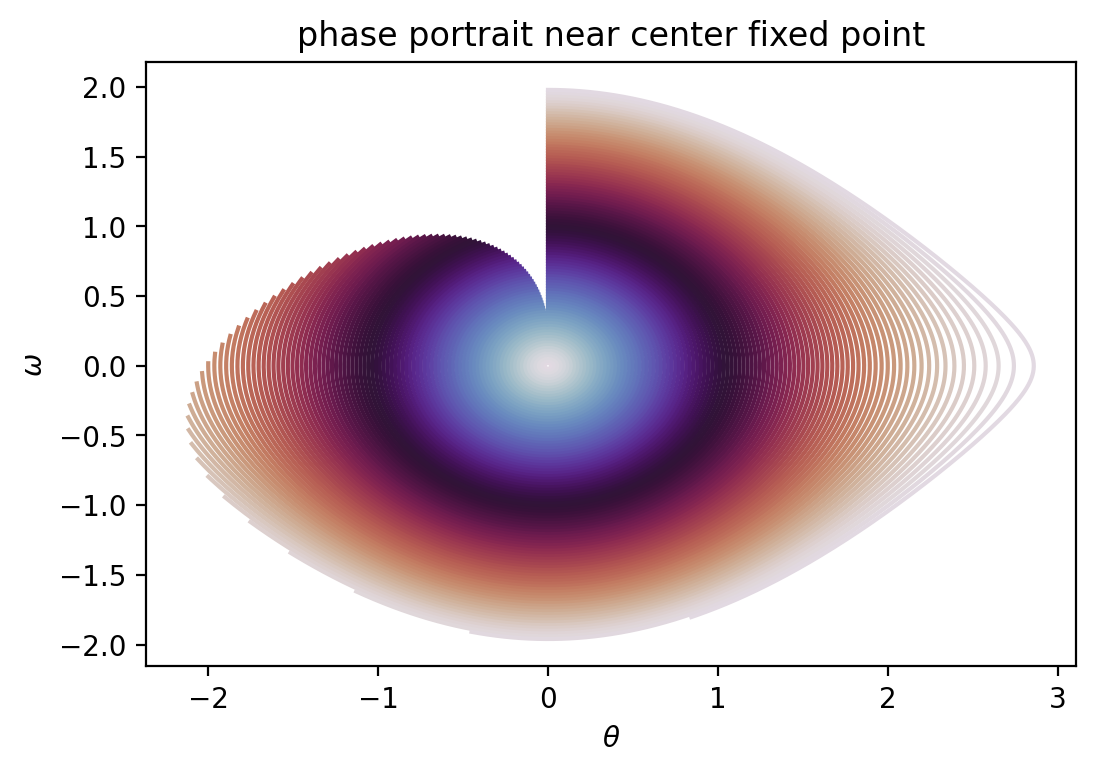

In [7]:
colors = plt.cm.twilight(np.linspace(0, 1, N))
plt.rc('axes', prop_cycle=cycler(color=colors))

plt.figure(dpi=200)
for i in range(N):
    plt.plot(data[i][:, 1], data[i][:, 2])
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\omega$')
plt.title('phase portrait near center fixed point')
#plt.show()

## Calculate oscillation periods

In [8]:
def event_sin_theta(t, s):
    return math.sin(s[0])

events = [event_sin_theta]

values = np.array([0.])
terminals = np.array([True])
directions = np.array([1])
counts = np.array([-1])
accurates = np.array([True])

call_event = EventsCodeGen(events).save_and_import()
rk_prop_ev = rk_module.rk_prop_ev

In [9]:
trjs = []
evs = []
for i in range(N):
    s0 = np.array([0., ws[i]])
    trj, evarr = rk_prop_ev(eq, s0, 0, 1000, np.inf, 1e-12, 1e-12,
                            values, terminals, directions, counts, accurates,
                            call_event, 1e-12, 1e-12, 100)
    trjs.append(trj)
    evs.append(evarr)

Text(0.5, 1.0, 'phase portrait near center fixed point')

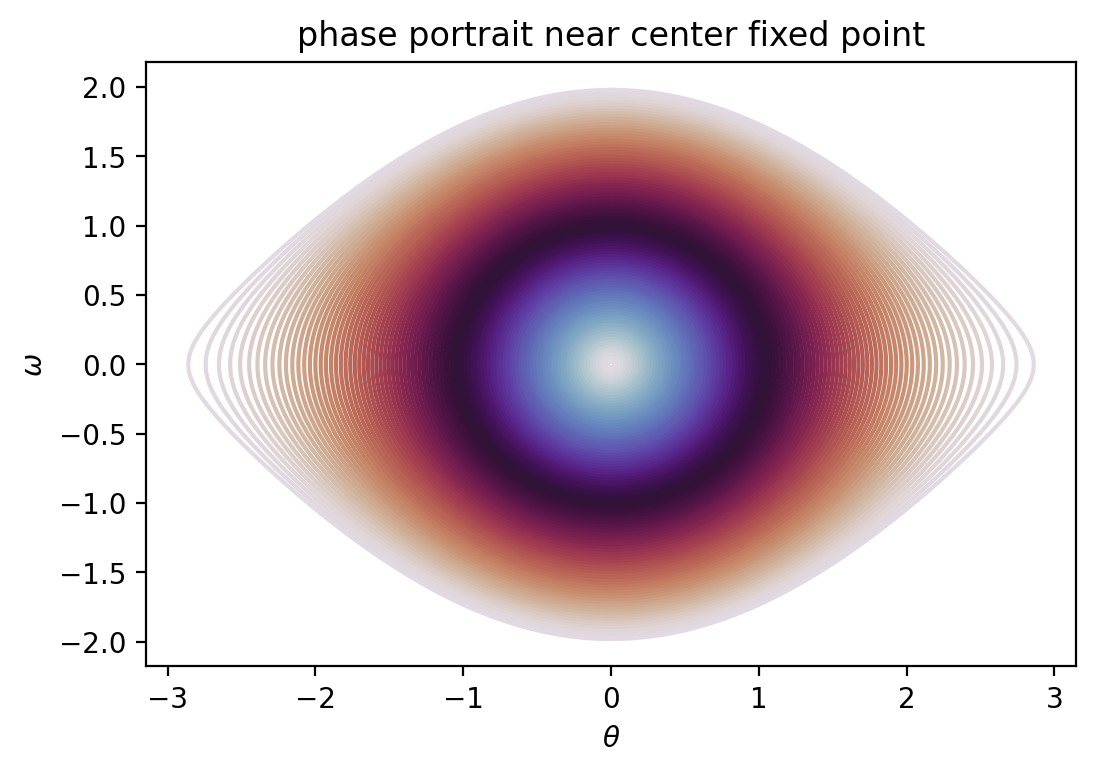

In [10]:
plt.figure(dpi=200)
for i in range(N):
    plt.plot(trjs[i][:, 1], trjs[i][:, 2])
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\omega$')
plt.title('phase portrait near center fixed point')

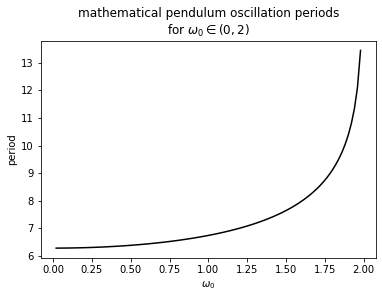

In [11]:
periods = np.array(evs)[:, 0, 2]
plt.plot(ws, periods, '-k')
plt.xlabel(r'$\omega_0$')
plt.ylabel(r'period')
plt.title('mathematical pendulum oscillation periods\nfor $\omega_0 \in (0, 2)$');